In [1]:
import digital_rf as drf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
import math, sys, os

from IPython.display import Audio, display

%matplotlib inline



In [2]:
def play(x, fs, autoplay=False):
    display(Audio(x, rate=fs, autoplay=autoplay))# Enable/disable playing of sounds

In [3]:
mpl.rcParams['font.size']      = 16
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

In [4]:
def plot_sig(x,fs,title=None,tlim=None,flim=None,figsize=(15,10)):
    """
    Plot signal and spectrogram.
    
    x:       signal
    fs:      sampling frequency
    title:   Overall title of plot
    tlim:    Time limits of waveform and spectrogram plots
    flim:    Frequency Limits of spectrogram and FFT plots
    figsize: Size of figure
    
    """
    N  = len(x)             # Number of samples in signal
    k  = np.arange(len(x))  # Integer time vector
    Ts = 1/fs               # Sampling Period
    
    # Set default time limits.
    if tlim is None:
        tlim = (0,np.max(k*Ts))
    
    fig = plt.figure(figsize=figsize) # Create figure.
    
    ### Plot the time domain waveform.
    ax  = fig.add_subplot(3,1,1)
    ax0 = ax
    ax.plot(k*Ts,x)
    ax.set_xlabel('kT [sec]')
    ax.set_ylabel('x(kT)')
    ax.set_xlim(tlim)
    
    if title is not None:
        ax.set_title(title)

    ### Plot the spectrogram  
    ax  = fig.add_subplot(3,1,2)
    ax1 = ax
    nperseg   = int(fs)           # 1 Hz resolution (df = fs/nperseg)
    noverlap  = int(0.75*nperseg) # 75% Overlap of Windows
    f, t, Sxx = signal.spectrogram(x, fs,window='hann',nperseg=nperseg,noverlap=noverlap)
    mpbl      = ax.pcolormesh(t, f, 10*np.log10(Sxx))
    ax.set_ylim(flim)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_xlim(tlim)
    plt.colorbar(mpbl,label='PSD [dB]',aspect=10,pad=0.02)
    
    ### Plot the average spectrum.    
    han_win = np.hanning(len(x))
    x_han   = han_win*x
    X_psd   = np.abs(np.fft.fftshift(np.fft.fft(x_han)*Ts*2))**2
    f       = np.fft.fftshift(np.fft.fftfreq(N,Ts))
    
    ax  = fig.add_subplot(3,1,3)
    ax2 = ax
    ax.plot(f,X_psd)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('PSD')
    
    if flim is not None:
        ax.set_xlim(-flim[1],flim[1])
        # ax.set_xlim(flim)
        
    plt.tight_layout()
    
    adjust_axes(ax0,ax1)
    adjust_axes(ax2,ax1)
    plt.show()
    
def adjust_axes(ax_0,ax_1):
    """
    Force geospace environment axes to line up with histogram
    axes even though it doesn't have a color bar.
    """
    ax_0_pos    = list(ax_0.get_position().bounds)
    ax_1_pos    = list(ax_1.get_position().bounds)
    ax_0_pos[2] = ax_1_pos[2]
    ax_0.set_position(ax_0_pos)

In [5]:
data_dir = "/home/cuong/drive/GRAPE2-SFTP/w2naf"
output_dir = 'output'

metadir = os.path.join(data_dir, "ch0", "metadata")
dro, dmr = drf.DigitalRFReader(data_dir), drf.DigitalMetadataReader(metadir)
fs = int(dmr.get_samples_per_second())
start_index, end_index = dro.get_bounds("ch0")


# User-defined variable: maximum number of hours to read
max_hours = 3  # TODO: Set the number of hours to read

# Calculate the maximum number of samples to read
max_samples = fs * 60 * 60 * max_hours

# Limit the end index based on the maximum number of samples to read
end_index = min(start_index + max_samples, end_index)

cont_data_arr = dro.get_continuous_blocks(start_index, end_index, "ch0")
batch_size_mins = 30
batch_size_samples = fs * 60 * batch_size_mins
read_iters = math.ceil((end_index - start_index) / batch_size_samples)
batches = []

start_sample = list(cont_data_arr.keys())[0]
channel = 0 # TODO: hard coded channel
for _ in tqdm(range(read_iters), desc="Reading Batches"):
    batch = dro.read_vector(start_sample, batch_size_samples, "ch0", 0)
    batches.append(batch)
    start_sample += batch_size_samples


data = np.concatenate(batches)


Reading Batches: 100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


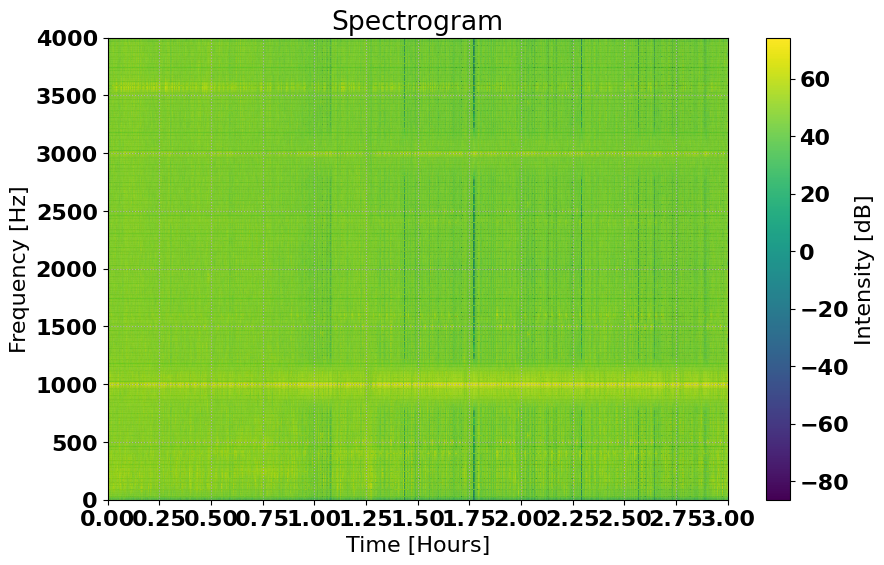

In [6]:
# Generate the spectrogram using scipy's spectrogram function
frequencies, times, Sxx = signal.spectrogram(data, fs=fs)

# Convert time values from seconds to hours
times_in_hours = times / 3600.0

# Plot the spectrogram
plt.figure(figsize=(10, 6))
# plt.ylim(990, 1010)
plt.pcolormesh(times_in_hours, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Hours]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')

# Ensure 13 evenly spaced x-ticks with units in hours
x_ticks = np.linspace(times_in_hours.min(), times_in_hours.max(), 13)
plt.xticks(x_ticks)
plt.gca().set_xticklabels([f"{x:.2f}" for x in x_ticks])
plt.show()
# # Save the spectrogram to a file
# output_file = os.path.join(output_dir, 'spectrogram.png')
# plt.savefig(output_file, format='png', dpi=300)
# plt.close()

# print(f"Spectrogram saved to {output_file}")

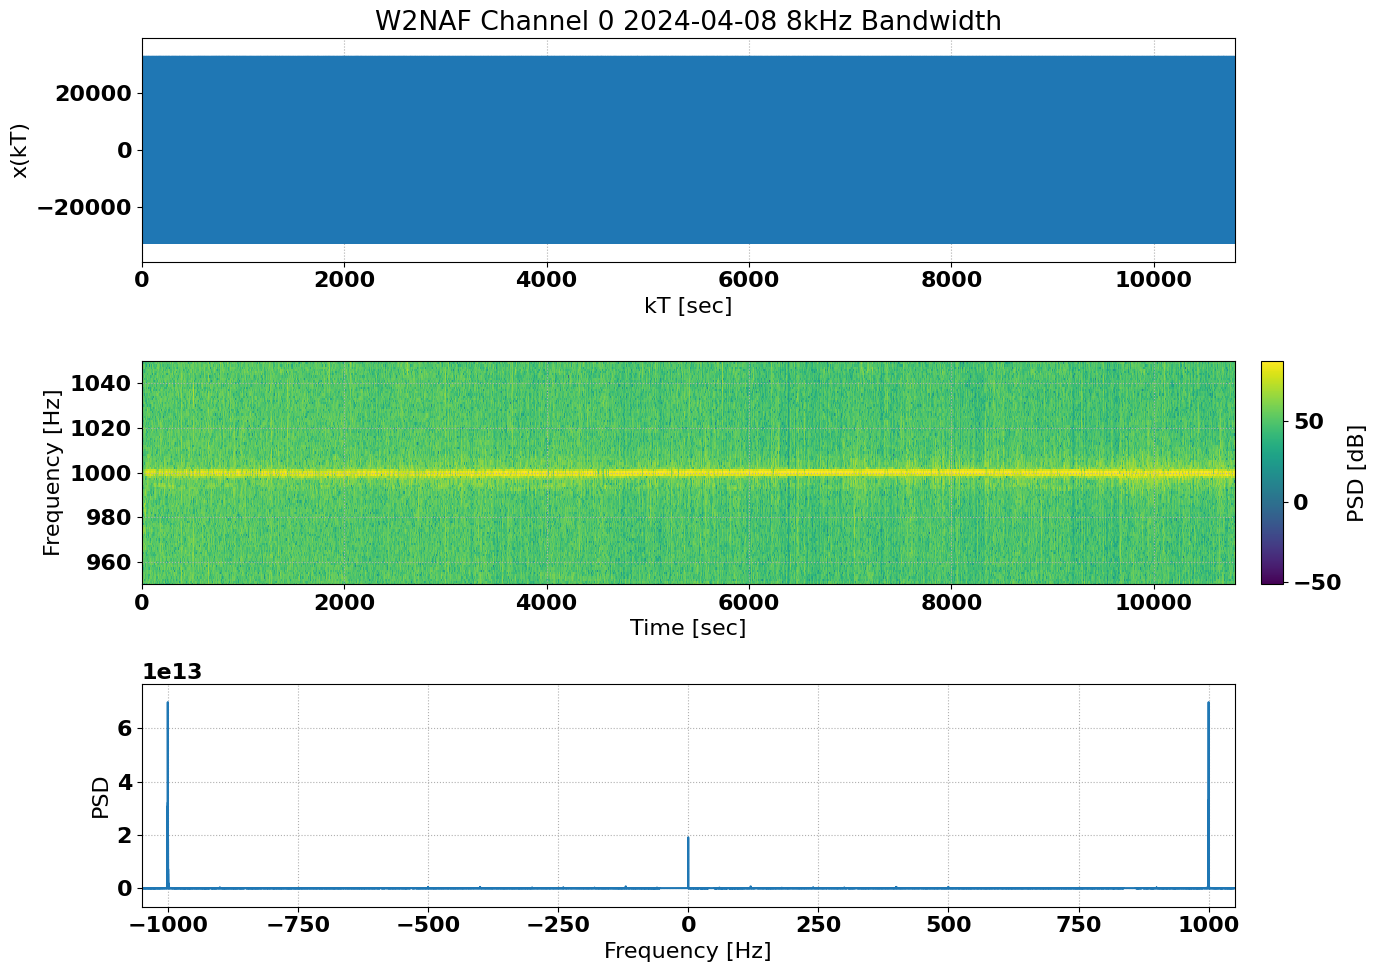

In [7]:
plot_sig(data,fs,title='W2NAF Channel 0 2024-04-08 8kHz Bandwidth', flim=(950, 1050))

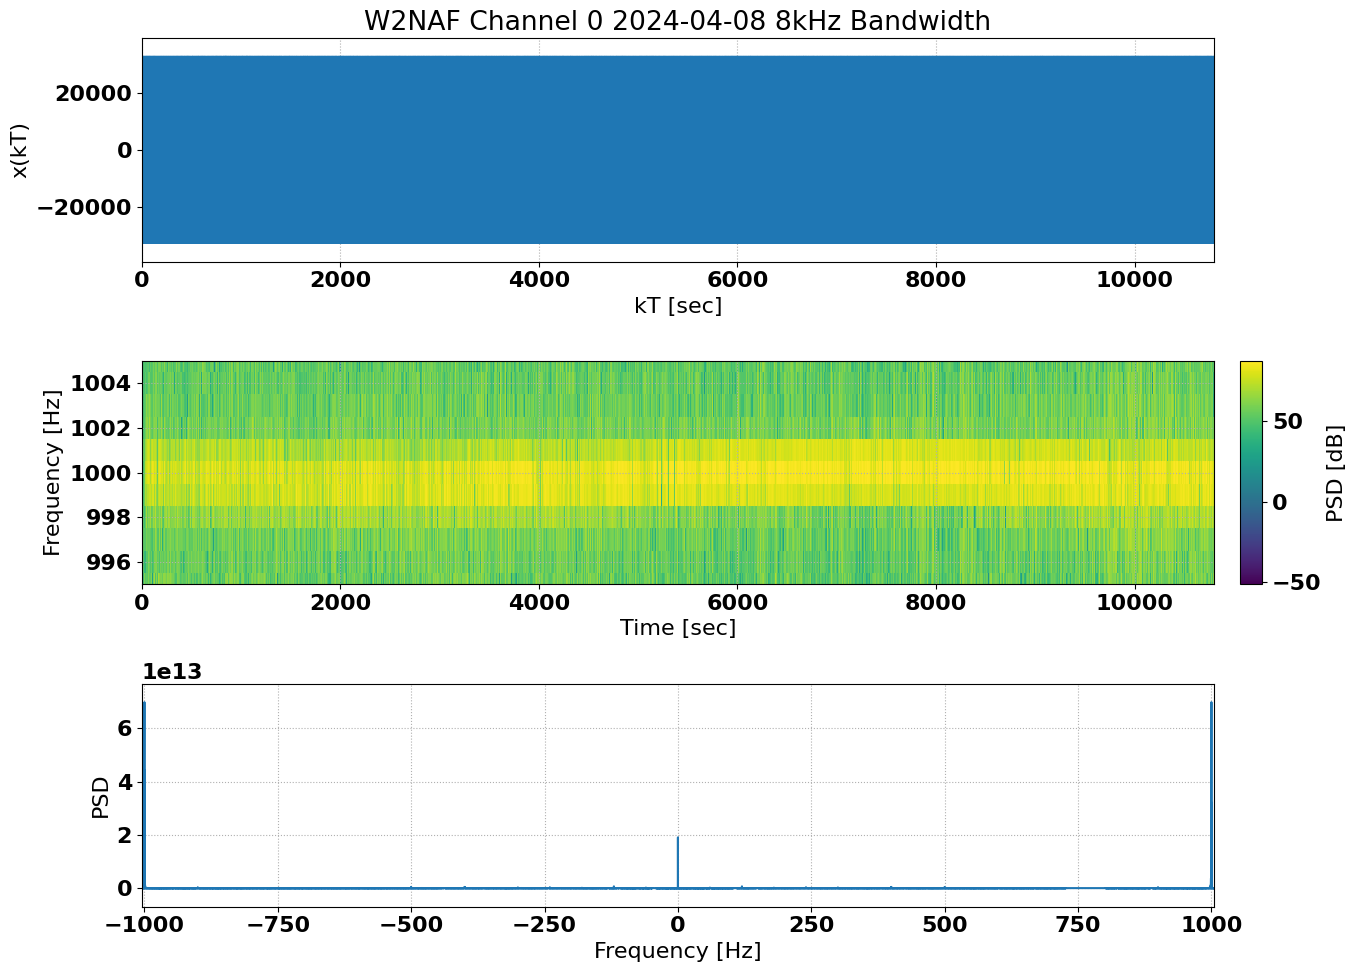

In [16]:
plot_sig(data,fs,title='W2NAF Channel 0 2024-04-08 8kHz Bandwidth', flim=(995, 1005))

In [9]:
f_c   = 1000
wp    = (f_c-10, f_c+10) # Band Pass Edge Frequencies
ws    = (f_c-20, f_c+20) # Band Stop Edge Frequencies

gpass =  3 # The maximum loss in the passband (dB).
gstop = 40 # The minimum attenuation in the stopband (dB).

N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
sos   = signal.butter(N, Wn, 'bandpass', fs=fs, output='sos')

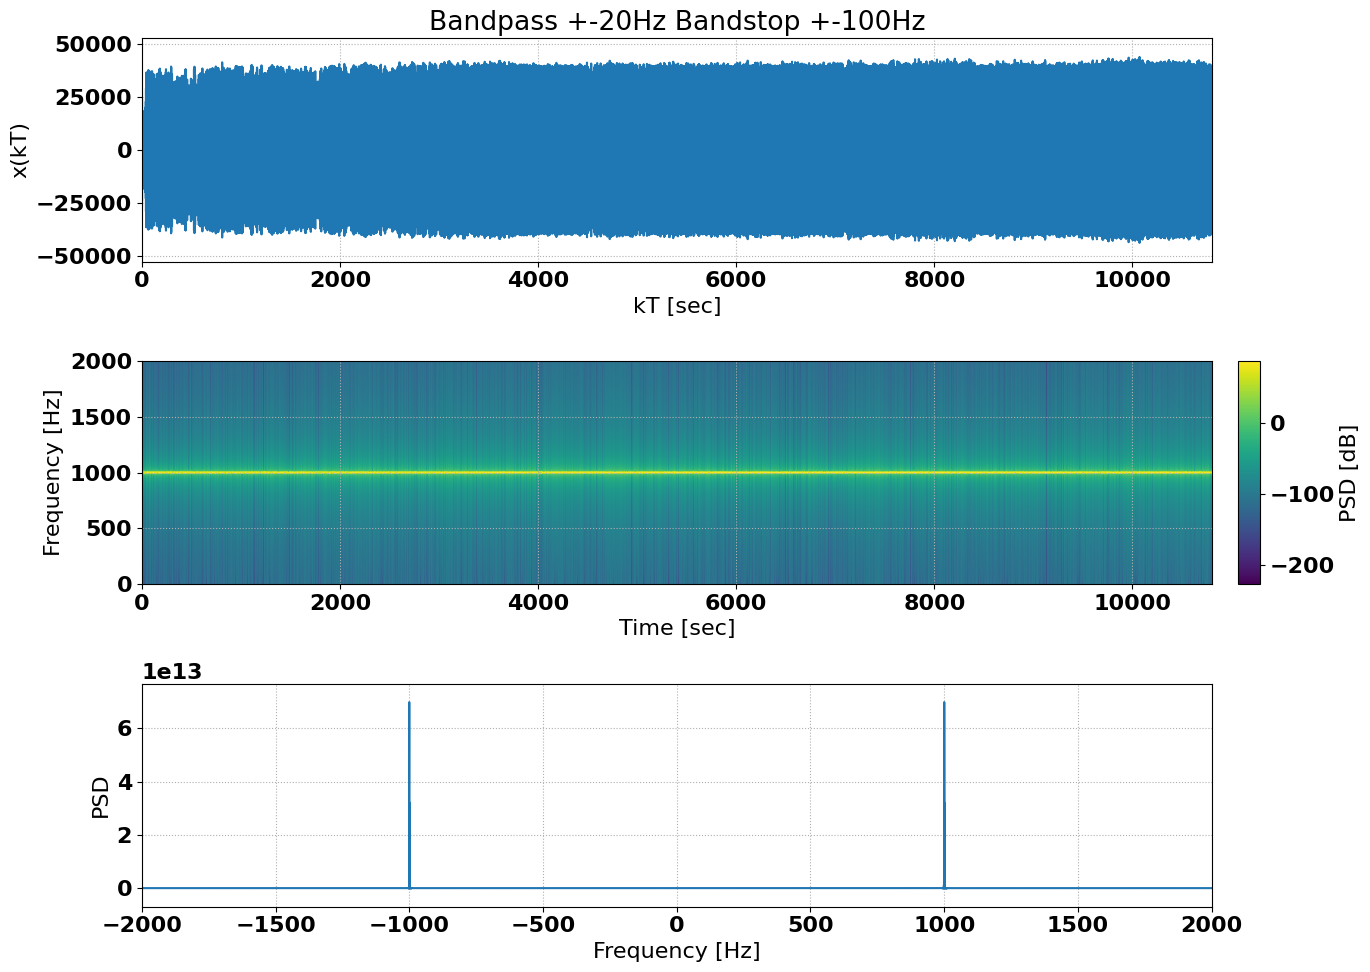

In [10]:
# Apply Filter to Signal
s_usb = signal.sosfiltfilt(sos,data)

# Plot Filtered Signal
title = 'Bandpass +-20Hz Bandstop +-100Hz'
plot_sig(s_usb,fs,title=title,flim=(0, 2000))

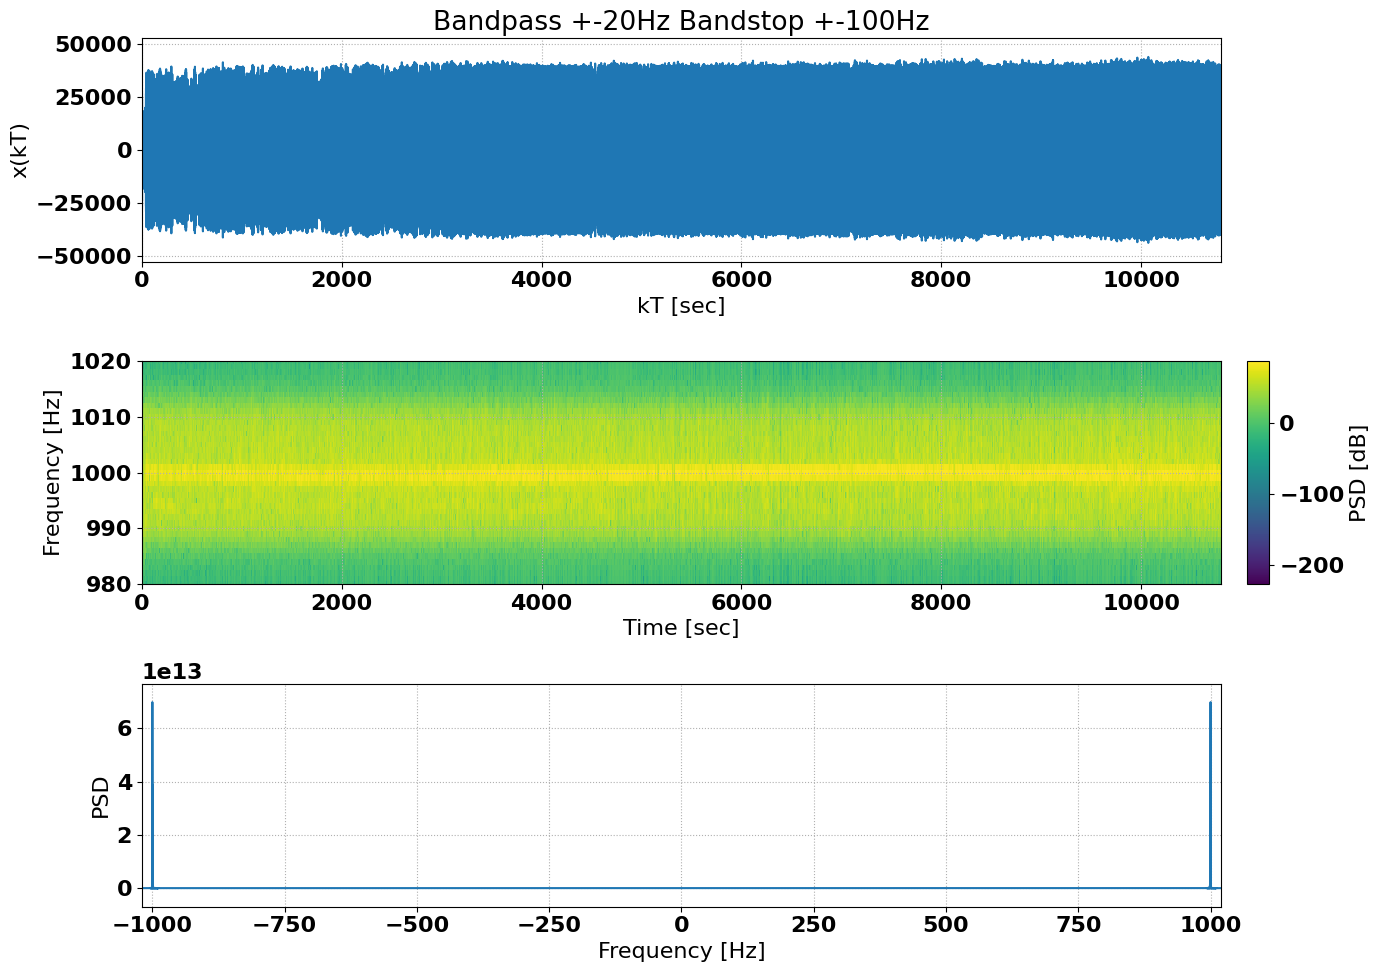

In [11]:
# Apply Filter to Signal
s_usb = signal.sosfiltfilt(sos,data)

# Plot Filtered Signal
title = 'Bandpass +-20Hz Bandstop +-100Hz'
plot_sig(s_usb,fs,title=title,flim=(980, 1020))

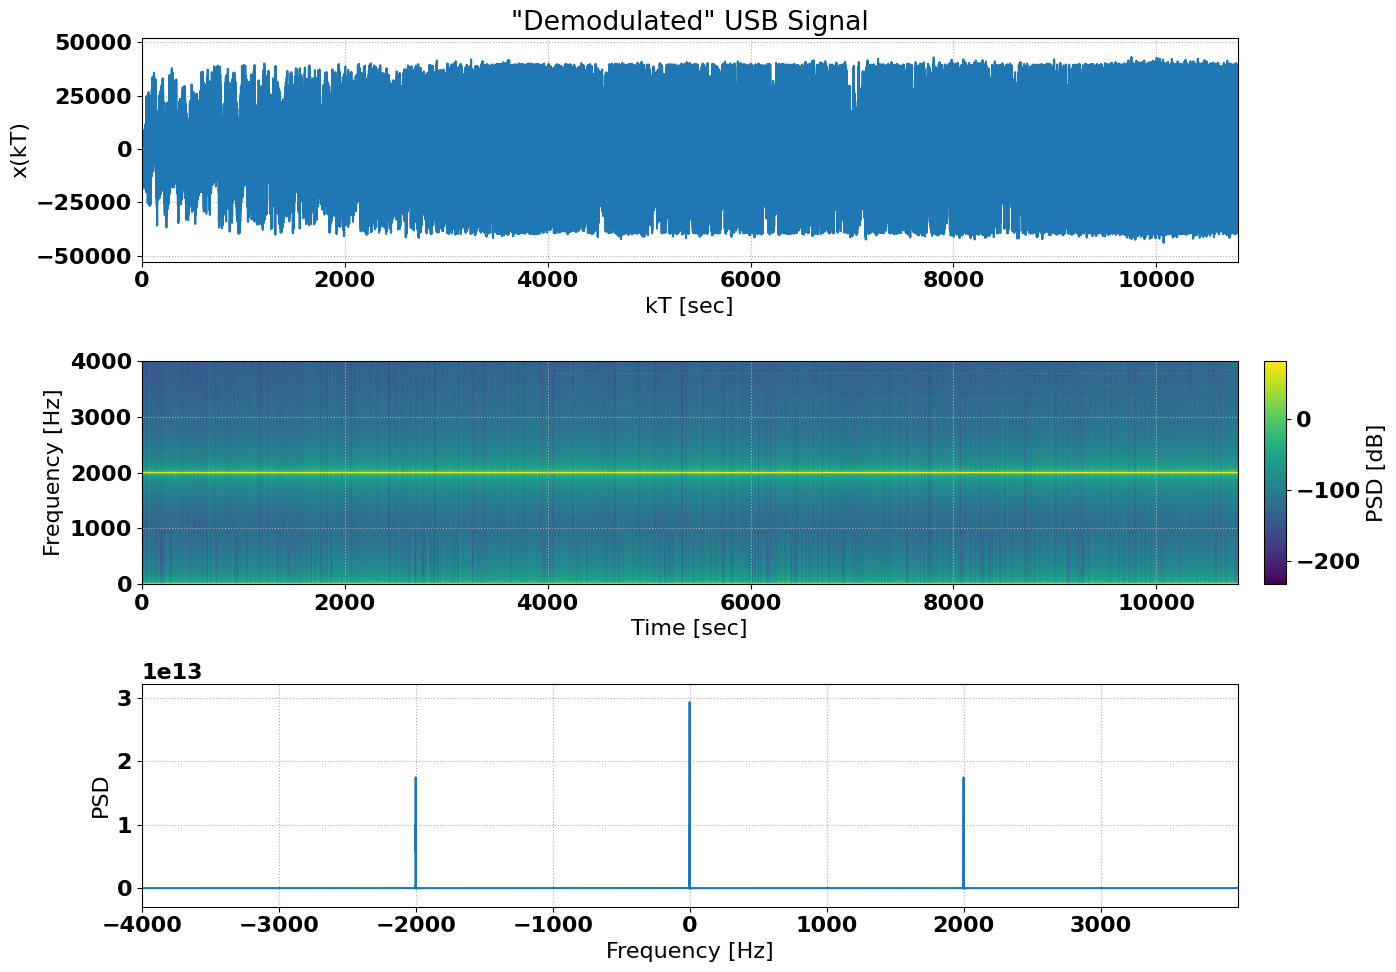

In [12]:
Ts    = 1/fs

t_vec = np.arange(len(data))*Ts

v0 = s_usb*np.cos(2*np.pi*f_c*t_vec)
# Plot Filtered Signal
title = '\"Demodulated\" USB Signal'
plot_sig(v0,fs,title=title,flim=None)

In [13]:
wp    = 20 # Band Pass Edge Frequencies
ws    = 100 # Band Stop Edge Frequencies

gpass =  3 # The maximum loss in the passband (dB).
gstop = 40 # The minimum attenuation in the stopband (dB).

N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

/tmp/ipykernel_28976/218439301.py:40: RuntimeWarning: divide by zero encountered in log10
  mpbl      = ax.pcolormesh(t, f, 10*np.log10(Sxx))


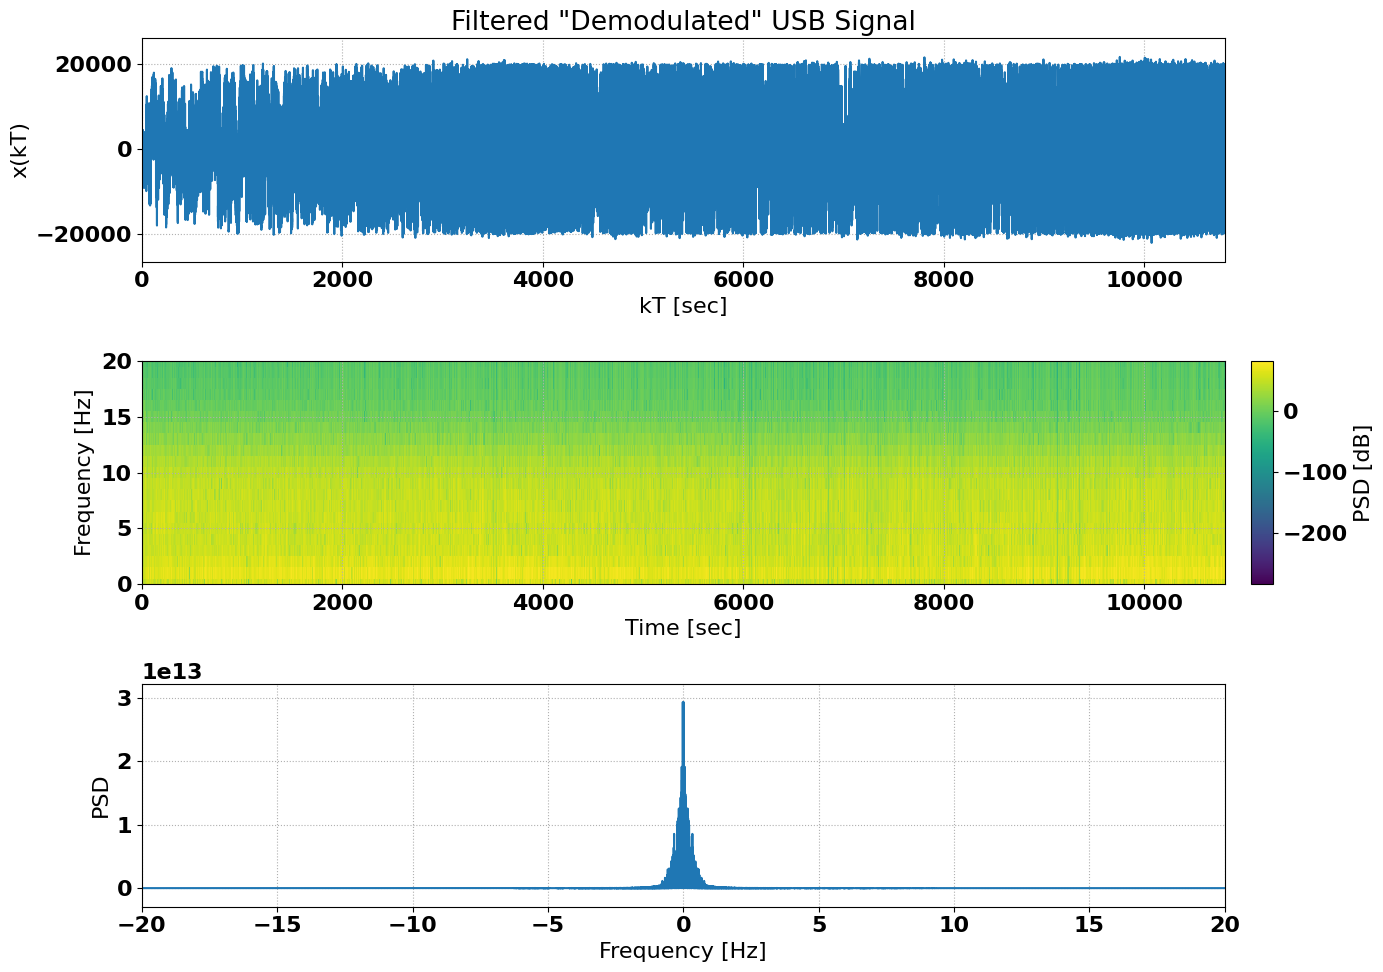

In [15]:
# Apply Filter to Signal
v1 = signal.sosfiltfilt(sos,v0)

# Plot Filtered Signal
title = 'Filtered \"Demodulated\" USB Signal'
plot_sig(v1,fs,title=title,flim=(0,20))